<a href="https://githubtocolab.com/geonextgis/cropengine/blob/main/docs/examples/Run wofost (single location).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

Uncomment the following line to install the latest version of [cropengine](https://geonextgis.github.io/cropengine) if needed.

In [14]:
# !pip install -U cropengine

## Import libraries

In [15]:
import os
import pandas as pd
import seaborn as sns
from cropengine import WOFOSTCropSimulationRunner
from cropengine.agromanagement import WOFOSTAgroEventBuilder

## User inputs

## Instantiate crop simulation engine for WOFOST

In [16]:
# Define the model name
MODEL_NAME = "Wofost81_PP"

# Initialize Engine
runner = WOFOSTCropSimulationRunner(
    model_name=MODEL_NAME, workspace_dir="test_output/location_workspace"
)

In [17]:
pd.DataFrame(runner.get_model_options())['id'].unique()

# [Wofost72_Phenology, Wofost72_PP, Wofost72_WLP_CWB, Wofost73_PP, Wofost73_WLP_CWB]

array(['Wofost72_Phenology', 'Wofost72_PP', 'Wofost72_WLP_CWB',
       'Wofost73_PP', 'Wofost73_WLP_CWB', 'Wofost81_PP',
       'Wofost81_WLP_CWB', 'Wofost81_WLP_MLWB', 'Wofost81_NWLP_CWB_CNB',
       'Wofost81_NWLP_MLWB_CNB', 'Wofost81_NWLP_MLWB_SNOMIN'],
      dtype=object)

In [6]:
# Location
LATITUDE = 53.3721
LONGITUDE = 13.82299

# Crop Configuration
# Note: Use runner.get_..._options() to see valid values if unsure
models = runner.get_model_options()
crops = runner.get_crop_options(MODEL_NAME)
CROP_NAME = "sugarbeet"
varieties = runner.get_variety_options(MODEL_NAME, CROP_NAME)
CROP_VARIETY = "Sugarbeet_601"

# Timing
crop_start_end = runner.get_crop_start_end_options()
CAMPAIGN_START = "2006-01-01"
CROP_START = "2006-04-05"
CROP_START_TYPE = "emergence"
CROP_END_TYPE = "harvest"
CROP_END = "2006-10-20"
CAMPAIGN_END = "2007-01-01"
MAX_DURATION = 300

## Create agromanagements with user inputs

In [7]:
agro_event_builder = WOFOSTAgroEventBuilder()

# Note: Use agro_event_builder.get_..._events_info() to see valid values if unsure
timed_events_info = agro_event_builder.get_timed_events_info()
state_events_info = agro_event_builder.get_state_events_info()

# Build timed events (irrigation)
irrigation_schedule = [
    {"event_date": "2006-05-25", "amount": 3.0, "efficiency": 0.7},
    {"event_date": "2006-06-30", "amount": 2.5, "efficiency": 0.7},
]

irrigation_events = agro_event_builder.create_timed_events(
    signal_type="irrigate", events_list=irrigation_schedule
)

# Build state Events (fertilization based on DVS)
nitrogen_schedule = [
    {"threshold": 0.3, "N_amount": 40, "N_recovery": 0.7},
    {"threshold": 0.6, "N_amount": 60, "N_recovery": 0.7},
    {"threshold": 1.12, "N_amount": 40, "N_recovery": 0.7},
]

nitrogen_events = agro_event_builder.create_state_events(
    signal_type="apply_n",
    state_var="DVS",
    zero_condition="rising",
    events_list=nitrogen_schedule,
)

## Prepare system (must be implemented before running the simulation)

In [8]:
runner.prepare_system(
    latitude=LATITUDE,
    longitude=LONGITUDE,
    campaign_start=CAMPAIGN_START,
    campaign_end=CAMPAIGN_END,
    crop_start=CROP_START,
    crop_start_type=CROP_START_TYPE,
    crop_end_type=CROP_END_TYPE,
    crop_end=CROP_END,
    max_duration=MAX_DURATION,
    crop_name=CROP_NAME,
    variety_name=CROP_VARIETY,
    timed_events=[irrigation_events],
    state_events=[nitrogen_events],
    force_update=False,
    force_param_update=True,
    site_overrides={'WAV': 10}  # Extra site params can be passed as overrides
)

[PREP] Preparing workspace: test_output/location_workspace
🚨 [WARN] Required site parameter 'NAVAILI' missing for model 'Wofost81_PP'. Using default value: 50.0
🚨 [WARN] Required site parameter 'CO2' missing (no YAML default). Using emergency fallback: 360.0
🚨 [WARN] Required crop parameter 'REALLOC_STEM_RATE' missing for model 'Wofost81_PP'. Using default value: 0.05
🚨 [WARN] Required crop parameter 'REALLOC_DVS' missing for model 'Wofost81_PP'. Using default value: 1.1
🚨 [WARN] Required crop parameter 'AMAX_SLP' missing for model 'Wofost81_PP'. Using default value: 23.5
🚨 [WARN] Required crop parameter 'REALLOC_LEAF_RATE' missing for model 'Wofost81_PP'. Using default value: 0.0
🚨 [WARN] Required crop parameter 'AMAX_LNB' missing for model 'Wofost81_PP'. Using default value: 0.25
🚨 [WARN] Required crop parameter 'AMAX_REF' missing for model 'Wofost81_PP'. Using default value: 1.0
🚨 [WARN] Required crop parameter 'DVS_N_TRANSL' missing for model 'Wofost81_PP'. Using default value: 0.5

## Get the parameters table to be displayed in the dashboard

### Soil parameters

In [9]:
soil_params = pd.read_csv(
    runner.files["soil_params"]
)
print(soil_params.shape)
soil_params.head()

(46, 4)


,parameter,description,unit,value
0,A0SOM,Initial age of soil organic material,year,NaN
1,BG_N_SUPPLY,Background supply of N through atmospheric dep...,kg/ha/day,NaN
2,CNRatioBio,C:N ratio of microbial biomass,kg C kg-1 N,NaN
3,CNRatioSOMI,Initial C:N ratio of soil organic matter,kg C kg-1 N,0.98
4,CONDfromPF,Table function of the 10-base logarithm of the...,log10(cm water d-1),NaN


In [10]:
site_params = pd.read_csv(
    runner.files["site_params"]
)
print(site_params.shape)
site_params.head()

(11, 8)


,parameter,required,value,default,range,type,description,unit
0,BG_N_SUPPLY,False,0.0,0.0,"[0.0, 0.1]",float,Background N supply through atmospheric deposi...,kg/ha/day
1,CO2,True,360.0,NaN,"[300.0, 1400.0]",float,Atmospheric CO2 concentration.,ppm
2,IFUNRN,False,0.0,0.0,"[0, 1]",int,Indicates whether non-infiltrating fraction of...,-
3,NAVAILI,True,50.0,50.0,"[0.0, 500.0]",float,Amount of N available in the pool at initializ...,kg/ha
4,NOTINF,False,0.0,0.0,"[0.0, 1.0]",float,Maximum fraction of rain not-infiltrating into...,-


In [11]:
crop_params = pd.read_csv(
    runner.files["crop_params"]
)
print(crop_params.shape)
crop_params.head()

(107, 5)


,parameter,description,unit,required,value
0,AMAXTB,maximum leaf CO2 assimilation rate as function...,"['-', 'kg.ha-1.hr-1']",False,"[0.0, 22.5, 1.0, 45.0, 1.13, 45.0, 1.8, 36.0, ..."
1,AMAX_LNB,Specific leaf nitrogen below which there is no...,kg N ha-1 leaf,True,0.25
2,AMAX_REF,Reference max assimilation rate (scaling factor).,-,True,1.0
3,AMAX_SLP,Slope of the relationship between AMAX and lea...,kg CO2 ha-1 hr-1 / kg N ha-1,True,23.5
4,CFET,correction factor transpiration rate,-,False,1.0


## Run the Simulation

In [12]:
simulation_output = runner.run_simulation(
    soil_overrides=None,  # Runtime soil params can be passed as overrides
    site_overrides=None,  # Runtime site parameters can be passed as overrides
    crop_overrides=None,  # Runtime crop parameters can be passed as overrides
    agro_file_path=None,  # Runtime agro_file_path if any
)

# Set day as index
simulation_output = simulation_output.set_index("day")
print(simulation_output.shape)
simulation_output.head()

[RUN] Initializing Wofost81_PP in test_output/location_workspace...
(366, 18)


,DVS,LAI,TAGP,WSO,WLV,WST,TSUM,TSUME,WRT,TRA,EVS,RD,SM,NamountSO,NamountLV,NamountST,NamountRT,NuptakeTotal
day,,,,,,,,,,,,,,,,,,
2006-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001149,NaN,0.3,NaN,NaN,NaN,NaN,NaN
2006-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.3,NaN,NaN,NaN,NaN,NaN
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.3,NaN,NaN,NaN,NaN,NaN
2006-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.3,NaN,NaN,NaN,NaN,NaN
2006-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026551,NaN,0.3,NaN,NaN,NaN,NaN,NaN


## Plot the simulation output

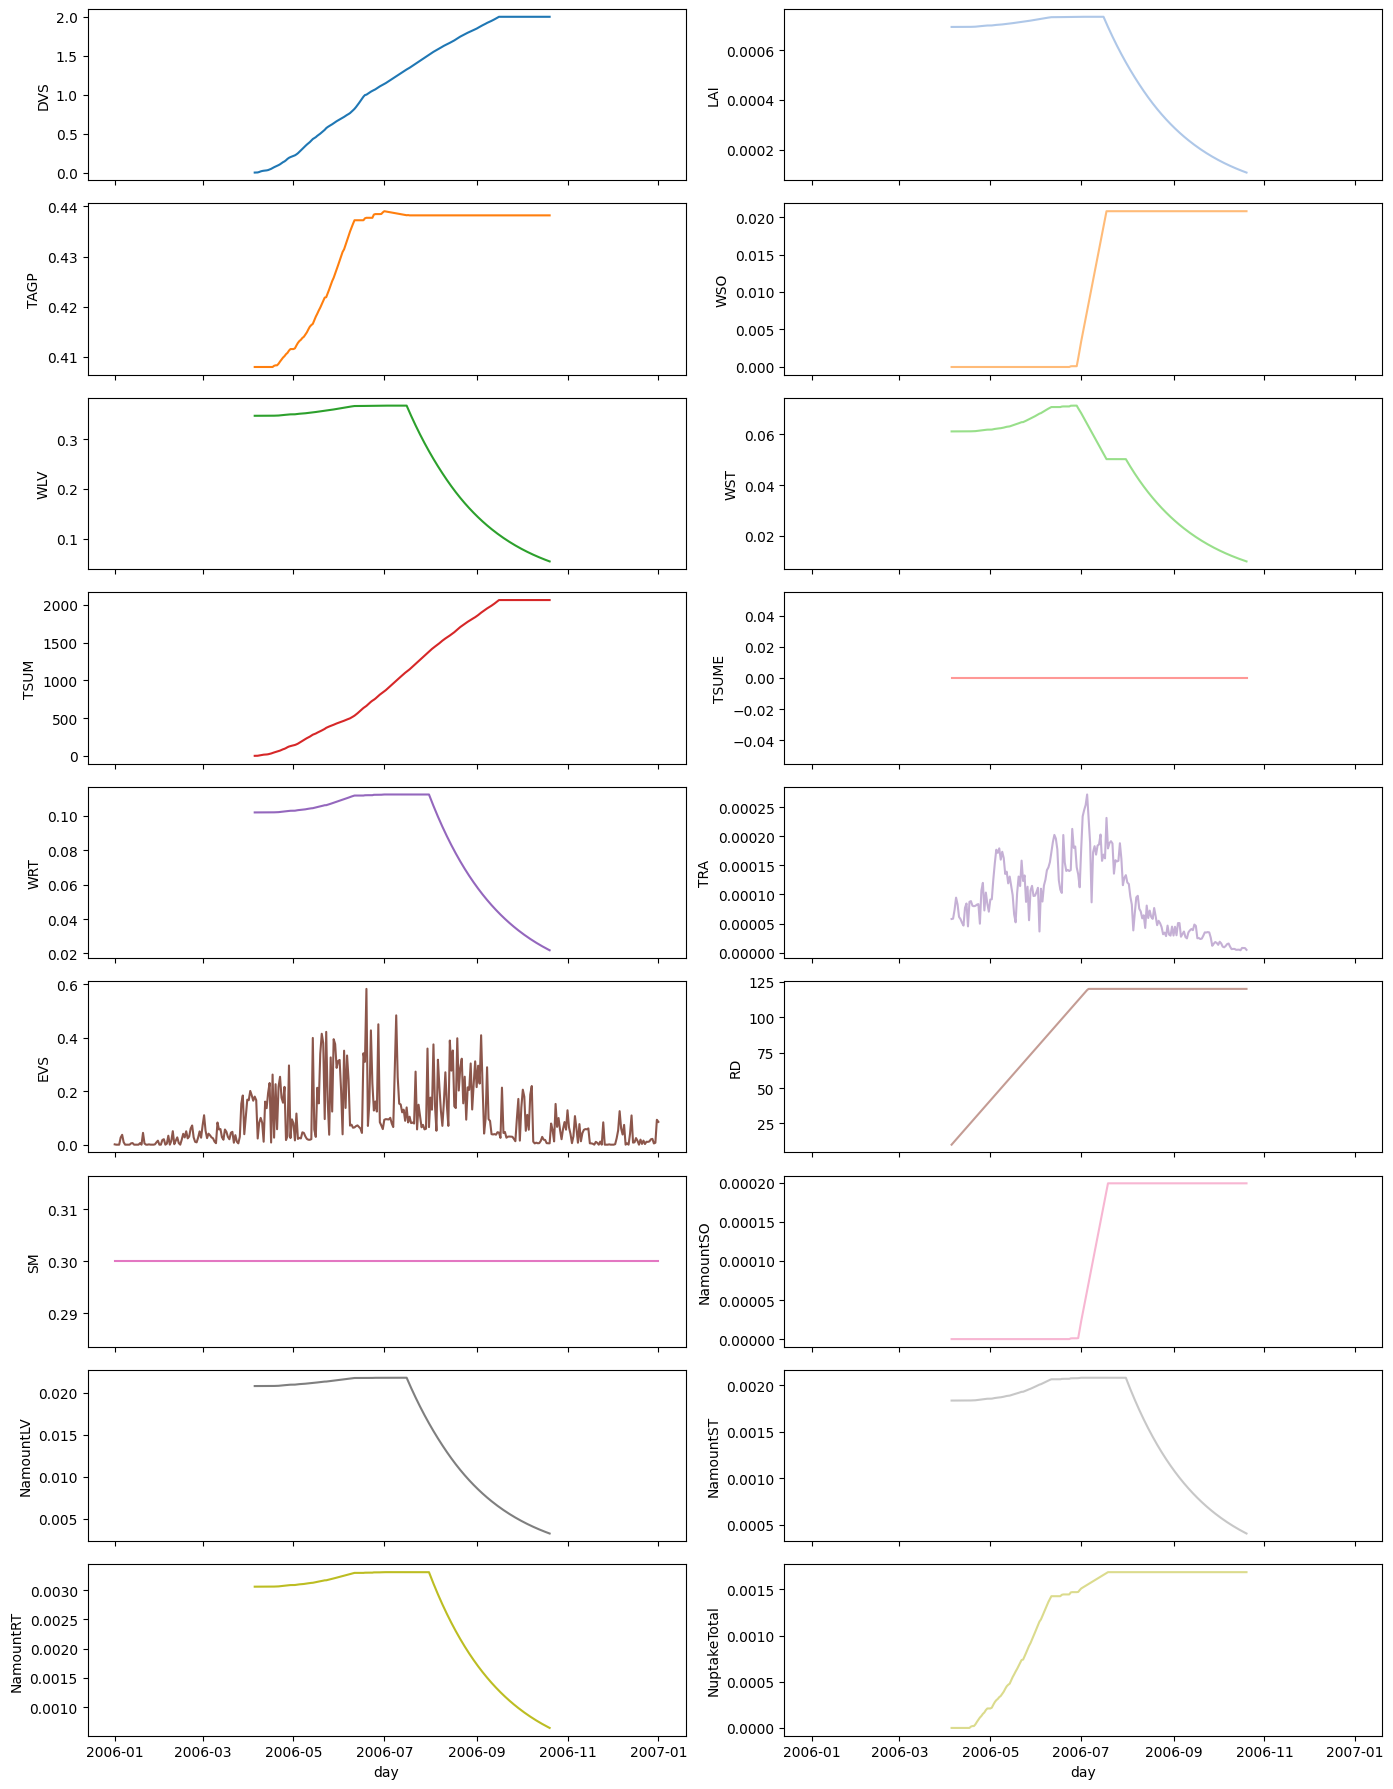

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Variables
cols = 2
n_vars = len(simulation_output.columns)
rows = math.ceil(n_vars / cols)

# Use a categorical color palette large enough
palette = sns.color_palette("tab20", n_vars)

fig, axes = plt.subplots(rows, cols, figsize=(14, 2 * rows), sharex=True)
axes = np.array(axes).reshape(-1)

for i, var in enumerate(simulation_output.columns):
    sns.lineplot(
        x=simulation_output.index,
        y=simulation_output[var],
        ax=axes[i],
        color=palette[i],
    )

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()